# Ejercicio 1 - Preparación del Ambiente de Trabajo

In [140]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re

from helpers import grid_plot_batch, identify_high_correlations, plot_classification_report

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')

In [3]:
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar
df.columns = [i.replace(' ', '') for i in df.columns]

In [4]:
# eliminamos el string de url que no sirve para el análisis
df = df.loc[:, 'n_tokens_title':'shares']

In [5]:
# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"), axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)

### Visualizamos los grupos de variables

In [23]:
qnty.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens
0,12.0,219.0,0.663594,1.0,0.815385
1,9.0,255.0,0.604743,1.0,0.791946
2,9.0,211.0,0.575130,1.0,0.663866
3,9.0,531.0,0.503788,1.0,0.665635
4,13.0,1072.0,0.415646,1.0,0.540890


IndexError: tuple index out of range

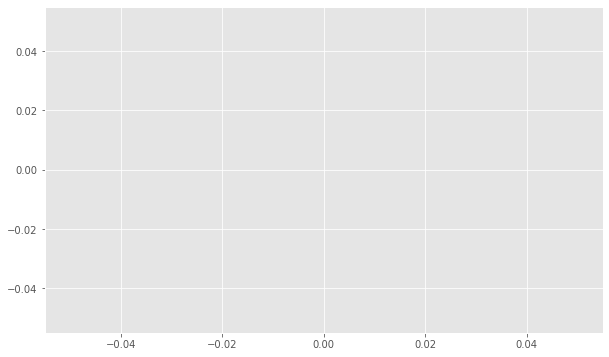

In [24]:
grid_plot_batch(qnty, 2, sns.distplot())

In [18]:
qnty

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens
0,12.0,219.0,0.663594,1.0,0.815385
1,9.0,255.0,0.604743,1.0,0.791946
2,9.0,211.0,0.575130,1.0,0.663866
3,9.0,531.0,0.503788,1.0,0.665635
4,13.0,1072.0,0.415646,1.0,0.540890
...,...,...,...,...,...
39639,11.0,346.0,0.529052,1.0,0.684783
39640,12.0,328.0,0.696296,1.0,0.885057
39641,10.0,442.0,0.516355,1.0,0.644128
39642,6.0,682.0,0.539493,1.0,0.692661


### Diagnóstico de multicolinealidad

In [28]:
correlations = identify_high_correlations(df, threshold=.7)

Los pares de atributos que presentan una correlación igual o superior a 0.8 son:

In [33]:
correlations[(correlations['value'] >= 0.8)|(correlations['value'] <= -0.8)][['variable', 'var2']].reset_index(drop=True)

,variable,var2
0,n_non_stop_words,n_unique_tokens
1,n_non_stop_unique_tokens,n_unique_tokens
2,n_non_stop_unique_tokens,n_non_stop_words
3,kw_avg_min,kw_max_min
4,kw_max_max,kw_min_min
5,kw_avg_avg,kw_max_avg
6,self_reference_avg_sharess,self_reference_min_shares
7,self_reference_avg_sharess,self_reference_max_shares
8,LDA_02,data_channel_is_world


### Pre-procesamiento

a) binaria 1 si tiene mas de 1400 shares

In [37]:
df['shares'] = np.where(df['shares'] > 1400, 1, 0)

b) Eliminacion variables con correlación superior a 0.8

In [39]:
correlations_08 = correlations[(correlations['value'] >= 0.8)|(correlations['value'] <= -0.8)]
correlations_08.head()

,variable,var2,value
179,n_non_stop_words,n_unique_tokens,0.999572
238,n_non_stop_unique_tokens,n_unique_tokens,0.999852
239,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1139,kw_avg_min,kw_max_min,0.940529
1256,kw_max_max,kw_min_min,-0.857226


In [43]:
# obtenemos todas las variables con correlacion mayor a 0.8
over_08 = list(pd.unique(correlations_08[['variable', 'var2']].values.ravel('K')))

In [50]:
# eliminamos variables con correlacion superior a 0.8
df = df.loc[:, df.columns[~df.columns.isin(over_08)]]

c) Utilizamos PCA para seleccionar las 30 principales dimensiones

In [55]:
from sklearn.decomposition import PCA
# PCA necesita tener los datos estandarizados
from sklearn.preprocessing import StandardScaler

#### Estandarizamos los datos

In [92]:
x = df.loc[:, df.columns[~df.columns.isin(['shares'])]].values
y = df.loc[:, 'shares'].values

In [94]:
x_std = StandardScaler().fit_transform(x)

#### Aplicamos PCA

In [95]:
# objeto PCA
pca = PCA()

In [96]:
# ajustamos los datos
componentes_principales = pca.fit_transform(x_std)

In [107]:
df_componentes = pd.DataFrame(data=componentes_principales, columns=df.columns[~df.columns.isin(['shares'])])

In [111]:
df_componentes[:2]

,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,-0.609857,0.388802,0.900434,-0.240299,-1.833938,-0.208243,-0.230784,-2.988238,1.334299,0.693038,...,0.686158,-0.802531,-0.316628,0.218063,-0.526840,0.015992,-0.408732,0.107216,-3.576261e-14,6.813612e-16
1,1.389403,-2.000910,0.381147,-3.072095,0.940077,-0.340678,-0.639871,-2.139515,-0.088194,-0.952283,...,0.257264,0.435609,0.173575,-0.139333,-0.187216,-0.045545,0.164735,0.067855,6.954258e-15,4.093531e-16


In [121]:
# generamos un dataframe con las features y su varianza explicada
df_explain = pd.DataFrame(data={
    'features': df_componentes.columns,
    'exp_variance': list(pca.explained_variance_)
})

In [126]:
# lista con top 30 features --> que tienen mayor varianza explicada
top_30_features = list(df_explain.sort_values(by='exp_variance', ascending=False)[:30]['features'])

In [128]:
# seleccionamos 30 mejores features para predecir
df_model = df.loc[:, top_30_features]

# Ejercicio 2 - Evaluación de modelos individuales

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

In [132]:
mat_atr = df_model.copy()
vec_obj = df['shares']

In [136]:
# split en conjuntos de entrenamiento vs prueba
X_train, X_test, y_train, y_test = train_test_split(mat_atr, vec_obj, test_size=.33, random_state=23679)

In [137]:
# estandarizamos los datos
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [172]:
# ajustamos modelos
logistic_model =  LogisticRegression(random_state=23679).fit(X_train_std, y_train)
kmeans_model = KMeans(n_clusters=6, random_state=23679).fit(X_train_std, y_train) # 6 ya que habian ese numero de clusters previos
dec_tree_1 = DecisionTreeClassifier(max_depth=1).fit(X_train_std, y_train)
dec_tree_4 = DecisionTreeClassifier(max_depth=4).fit(X_train_std, y_train)

In [173]:
predictions_1 = {
    'Logistic Regression': logistic_model.predict(X_test_std),
    'KMeans': kmeans_model.predict(X_test_std)}

In [174]:
predictions_2 = {
    'Decision Tree max_depth=1': dec_tree_1.predict(X_test_std),
    'Decision Tree max_depth=4': dec_tree_4.predict(X_test_std)}

In [175]:
for model_, prediction_ in predictions_1.items():
    print(model_)
    print(classification_report(y_test, prediction_))

Logistic Regression
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      6528
           1       0.64      0.60      0.62      6555

    accuracy                           0.63     13083
   macro avg       0.63      0.63      0.63     13083
weighted avg       0.63      0.63      0.63     13083

KMeans
              precision    recall  f1-score   support

           0       0.59      0.51      0.55      6528
           1       0.56      0.22      0.32      6555
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.37     13083
   macro avg       0.19      0.12      0.14     13083
weighted avg       0.57      0.37      0.43     13083



In [176]:
for model_, prediction_ in predictions_2.items():
    print(model_)
    print(classification_report(y_test, prediction_))

Decision Tree max_depth=1
              precision    recall  f1-score   support

           0       0.53      0.87      0.66      6528
           1       0.65      0.23      0.35      6555

    accuracy                           0.55     13083
   macro avg       0.59      0.55      0.50     13083
weighted avg       0.59      0.55      0.50     13083

Decision Tree max_depth=4
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      6528
           1       0.64      0.53      0.58      6555

    accuracy                           0.62     13083
   macro avg       0.62      0.62      0.61     13083
weighted avg       0.62      0.62      0.61     13083



A partir de los resultados anteriores:

* Logistic Regression demostró ser quien mejor explica la popularidad del contenido, entregando un accuracy de un 63%, seguido por un árbol de decisión con profundidad 4 con un 62%, luego por un árbol de decisión de profundidad unitaria con 55%, y finalmente por KMeans con 26%
* La precision y el recall se mantuvieron sobre el 60% para la regresión logística, entregando un F1 score promedio de 63%

# Ejercicio 3 - Entrenamiento de Comité

In [164]:
from sklearn.ensemble import VotingClassifier

In [177]:
estimators = [('Logistic Regression', LogisticRegression(random_state=23679)),
              ('KMeans', KMeans(n_clusters=6, random_state=23679)),
              ('Decision Tree Classifier max_depth=1', DecisionTreeClassifier(max_depth=1)),
              ('Decision Tree Classifier max_depth=4', DecisionTreeClassifier(max_depth=4))]

In [178]:
voting_classifier = VotingClassifier(estimators).fit(X_train_std, y_train)

ValueError: The estimator KMeans should be a classifier.